In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import re

##### Feactures description of the dataset https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [2]:
# The above link conteins the description of the dataset including the categories of the ordinal and Nominal
# which are good data to find realationship with the SalePrice feature. Working in this dataset i found that
# some variables in the page are different than in the dataset. So i changed manually the name of some variable 
# txt file to make a match with the names of the dataset. The next two lines of code shows the features with
# differences in the names.
# a = set(data.columns.tolist()) - set(df_description['Variable'].tolist())
# a = [x for x in data.columns.tolist() if x not in df_description['Variable'].tolist()]

In [3]:
data = pd.read_csv('AmesHousing.csv')
data.shape

(2930, 82)

In [4]:
col_names = data.columns.tolist()

In [5]:
# Reading the data description provided by the dataset creator
try:
    with open('DataDocumentation.txt', 'r', encoding='latin-1') as file:
        content = file.read()
except FileNotFoundError:
    print('Error')


In [6]:
# Now read each line and look for the variable name, type and the description with the regex code
# Then split then to make a dict and later and DataFrame
features_description = []
pattern = re.compile(r'^\s*(.+?)\s*\((.*?)\):\s*(.*)$')
option_pattern = re.compile(r'^\s+(.+?)\s+(.*)$')
options_list = []
for line in content.strip().split('\n'):
    line = line.strip()
    if not line:
        continue

    match = pattern.match(line)
    if match:
        variable = match.group(1).strip()
        type_var = match.group(2).strip()
        description = match.group(3).strip()
        
        features_description.append({
            'Variable':variable,
            'Type Variable': type_var,
            'Description':description,
        })
        
df_description = pd.DataFrame(features_description)
print(len(df_description))
print(len(data.columns))

82
82


In [7]:
len(data['Exterior 2nd'].unique())

17

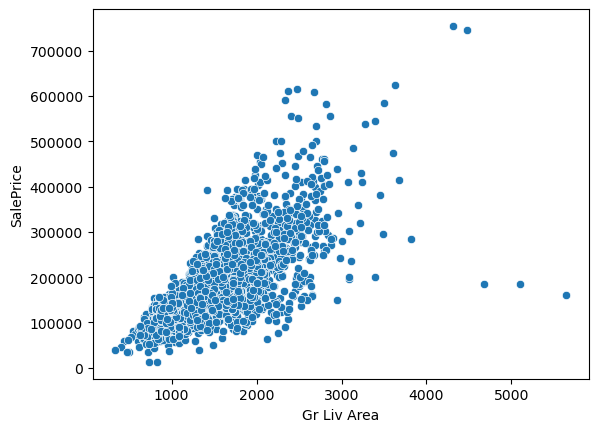

In [8]:
sns.scatterplot(data=data, x='Gr Liv Area', y='SalePrice')
plt.show()

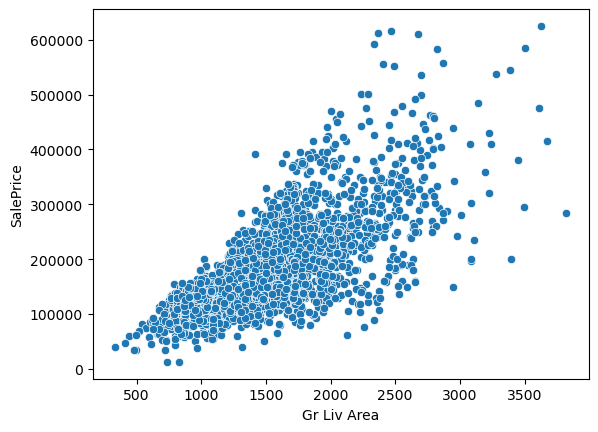

In [9]:
# The authors advice eliminate the rows with Gr Liv Area more than 4000 ft2. Which are considerated as outliers
df = data[data['Gr Liv Area']<4000]
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.show()

In [10]:
#Identification of features with most of the 60% of missing values
def null_features_identification(df):
    columnas = df.columns    
    drop_columns = []
    for i in columnas:
        if len(df[df[i].isna()])/(len(df)) > 0.6:
            drop_columns.append(i)
    return drop_columns

null_columns = null_features_identification(df)
print(null_columns)

['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']


In [11]:
#Let's make a list of columns to drop, to have a model with less features.
#the first are going to be the features with more than 60% of missing values and the identifiers columns 'Oder' and 'PID'AmesHousing.csv
drop_columns = null_columns + ['Order', 'PID']

In [12]:
df_1 = df.drop(columns=drop_columns)

In [13]:
# Now it's time to separate the two classes of variables (continuos and categorical) to discard to discard
#Variable with low variance which provides poor information about the SalePrice of Homes
numeric_cols = df_1.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_1.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['SalePrice', 'PID', 'Order' ]]

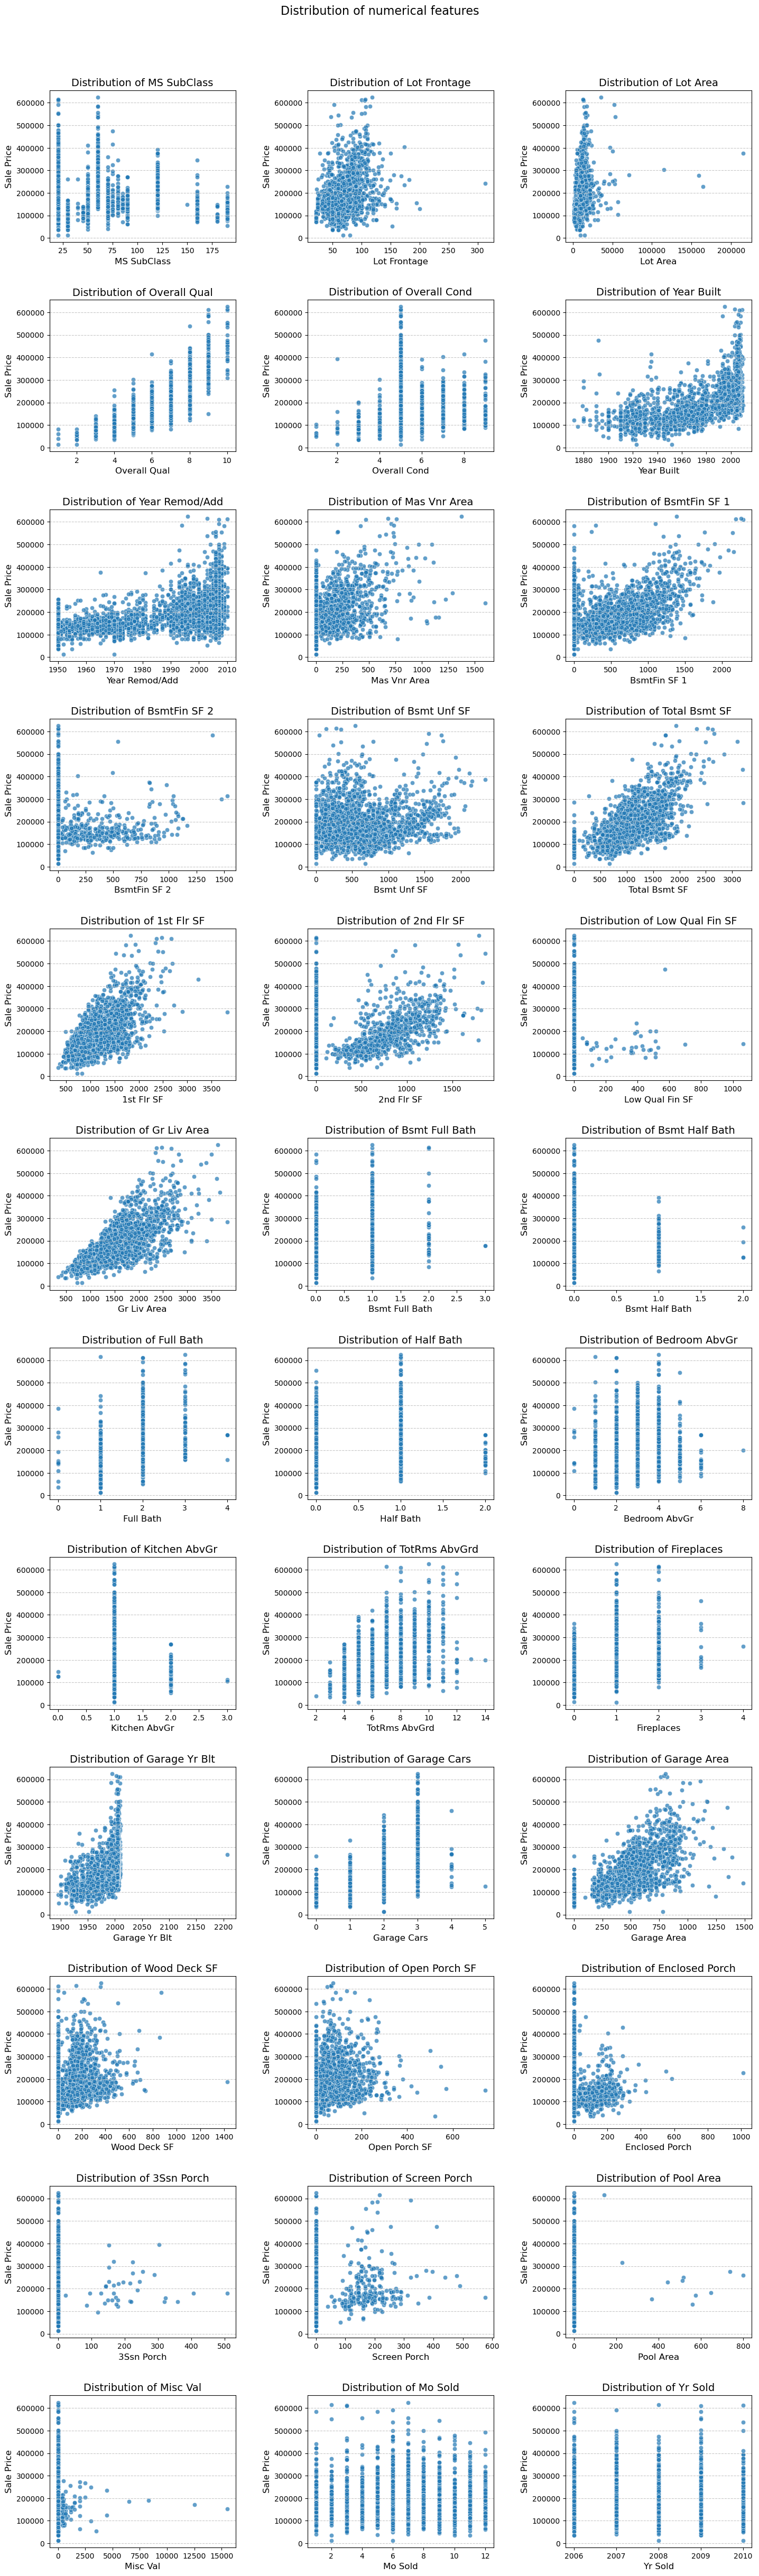

In [14]:
n_cols = 3
n_rows = (len(numeric_cols)+n_cols-1) // n_cols
plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    sns.scatterplot(x=df[col], y=df['SalePrice'], alpha=0.7)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Sale Price', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout(pad=3.0)
plt.suptitle('Distribution of numerical features', fontsize=16, y=1.02)
plt.show()

Most of the scatter plots of the numeric varibales shows a linear relationship againts SalePrice.  
Even the ordinal categorical features with positives uptrends.  
One clear outliers that could be seen is in the Garage Yr Blt with a value greather than 2200.  

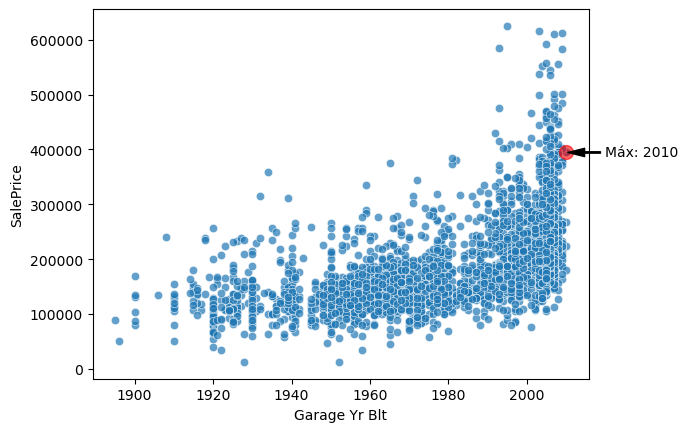

In [15]:
# Discarding atypical values in the feature 'Garage Yr Blt'
df_1 = df_1[df_1['Garage Yr Blt'] < 2025]
max_Garage_Yr_Blt = df_1.loc[df_1['Garage Yr Blt'].idxmax()]
x_max = max_Garage_Yr_Blt['Garage Yr Blt']
y_at_x_max = max_Garage_Yr_Blt['SalePrice']

sns.scatterplot(data=df_1, x='Garage Yr Blt', y='SalePrice', alpha=0.7)
plt.plot(max_Garage_Yr_Blt['Garage Yr Blt'], max_Garage_Yr_Blt['SalePrice'], 'ro', markersize=10, alpha=0.6)
plt.annotate(f'Máx: {int(x_max)}',
            xy=(x_max, y_at_x_max),
            xytext=(x_max + 10, y_at_x_max), # Ajusta la posición del texto
            ha='left', va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))
plt.show()

In [16]:
# To reduce the number of variables and don't waste resorces, its important drop features with low relevance for the data 
# so that means, features with low variance don't give much information to predict future behavior
# Variables with a variance lower than 5% will be drop and with categorical feature too, values with 95% dominance 
# in the category should be droped too
def low_variance_numeric_features(df, columns_names, threshold=0.05):
    variance_columns = {}

    for col in columns_names:
        if df[col].mean() != 0:
            cv = df[col].std() / abs(df[col].mean())
            variance_columns[col] = cv

    variance_columns = pd.DataFrame(list((variance_columns).items()))
    variance_columns.columns = ['Feature', 'Variance']
    feature_names = variance_columns[variance_columns['Variance']<=threshold]['Feature']
    return list(feature_names)

low_numeric_feature_variance = low_variance_numeric_features(df_1, numeric_cols)
low_numeric_feature_variance

['Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Yr Sold']

In [17]:
def low_variance_categorical_features(df, columns_names, threshold=0.95):
    variance_columns = {}

    for col in columns_names:
        variance_columns[col] = df[col].value_counts(normalize=True).max()
        
    
    variance_columns = pd.DataFrame(list((variance_columns).items()))
    variance_columns.columns = ['Feature', 'Frequency']
    feature_names = variance_columns[variance_columns['Frequency']>threshold]['Feature']
    return list(feature_names)

low_categorical_feature_variance = low_variance_categorical_features(df_1, categorical_cols)
low_categorical_feature_variance

['Street',
 'Utilities',
 'Land Slope',
 'Condition 2',
 'Roof Matl',
 'Heating',
 'Central Air',
 'Garage Cond']

In [18]:
# Elimination of low variance features of the data set. These variables don't bring enought information and generates noise
df_2 = df_1.drop(columns=low_numeric_feature_variance+low_categorical_feature_variance)
df_2.shape

(2765, 63)

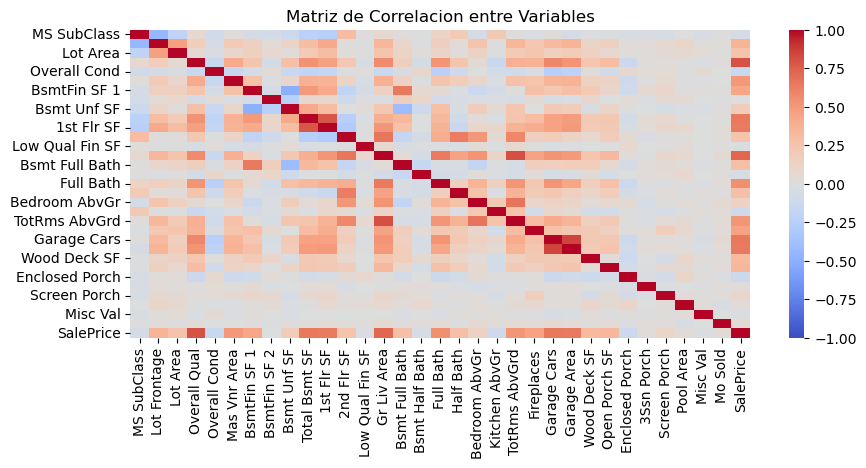

In [19]:
#Another way to discard unnecesary variables is identify variables highly correlated. Plotting the correlation matrix
#Cloud is a good way to identify them. Next the variables with a correlation upper than 0.8 will also drop
correlation_matrix = df_2.corr(numeric_only=True)

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Matriz de Correlacion entre Variables')
plt.show()

In [20]:
mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
corr_feature = correlation_matrix.where(mask)
high_corr = [column for column in corr_feature.columns if any(corr_feature[column].abs() > 0.8) and column != 'SalePrice']

print("Variables with high correlation: ", high_corr)

Variables with high correlation:  ['TotRms AbvGrd', 'Garage Area']


In [21]:
# Elimination of features with high colinearity
df_3 = df_2.drop(columns=high_corr)
df_3.shape

(2765, 61)

In [22]:
var_types = df_description['Type Variable'].unique().tolist()
var_types

['Discrete', 'Nominal', 'Continuous', 'Ordinal']

In [23]:
df_3.drop(columns=['SalePrice']).columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Lot Shape',
       'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond',
       'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Garage Qual', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
       'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Sale Type',
       'Sale

In [24]:
def variables_classification(descriptive_data, working_data, types):
    clasified_var = {}
    for i in types:
        cond = set(descriptive_data[descriptive_data['Type Variable'] == i]['Variable'])
        var_list = [x for x in working_data.columns if x in cond]
        clasified_var[i] = var_list
    return clasified_var

var_clasified = variables_classification(df_description, df_3.drop(columns=['SalePrice']), var_types)

In [25]:
set(df_description[df_description['Type Variable'] == i]['Variable'])

set()

In [26]:
df_3['Bsmt Cond'].isna().sum()

np.int64(66)

In [27]:
# The Overall Qual and Overall Cond must be deleted, because these variables are already transformed 
elements_to_remove = ['Overall Qual', 'Overall Cond']
var_clasified['Ordinal'] = [x for x in var_clasified['Ordinal'] if x not in elements_to_remove]

In [28]:
# Craeting the list of ordinal values by category 
def parse_ordinal_features(text):
    lines = text.strip().split('\n')
    
    ordinal_features = {} 
    
    current_variable = None
    current_type = None
    current_values = []
    
    for line in lines:
        line = line.strip()
        
        if '(' in line and ')' in line and ':' in line:
            if current_variable and current_values and current_type and current_type.lower() == 'ordinal':
                ordinal_features[current_variable] = current_values.copy()
            
            parts = line.split('(')
            var_name = parts[0].strip()
            type_part = parts[1].split(')')[0].strip()
            
            current_variable = var_name
            current_type = type_part
            current_values = []
            
        elif (current_variable and current_type and current_type.lower() == 'ordinal' 
                and line and not line.startswith(' ') and len(line.split()) >= 2):
            
            code = line.split()[0]
            
            if not any(word in code.lower() for word in ['lot', 'type', 'general', 'size']):
                current_values.append(code)
                
    
    if current_variable and current_values and current_type and current_type.lower() == 'ordinal':
        ordinal_features[current_variable] = current_values.copy()
    
    return ordinal_features

categories_ordinal_variables = parse_ordinal_features(content)
ordinal_order = [categories_ordinal_variables[x] for x in var_clasified['Ordinal']]

ordinal_order = [x + ['NA'] if 'NA' not in x else x for x in ordinal_order]
ordinal_order

[['Reg', 'IR1', 'IR2', 'IR3', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Gd', 'Av', 'Mn', 'No', 'NA'],
 ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
 ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Fin', 'RFn', 'Unf', 'NA'],
 ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
 ['Y', 'P', 'N', 'NA']]

In [50]:
preprocessor = ColumnTransformer(transformers=[
    ('cont', StandardScaler(), var_clasified['Continuous']),
    ('nom', OneHotEncoder(handle_unknown='ignore', drop='first'), var_clasified['Nominal']),
    ('ord', OrdinalEncoder(categories=ordinal_order, 
                        handle_unknown='use_encoded_value', unknown_value=-1), var_clasified['Ordinal'])
])

In [51]:
for col in var_clasified['Ordinal']:
    df_3[col] = df_3[col].fillna('NA')

for col in var_clasified['Continuous'] or var_clasified['Discrete']:
    df_3[col] = df_3[col].fillna(0)

In [52]:
model  =Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5))
])

In [53]:
X = df_3.drop(columns=['SalePrice'])
y = df_3['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['Lot Frontage', 'Lot Area',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   'Enclosed Porch',
                                                   '3Ssn Porch', 'Screen Porch',
                                                   'Pool Area', 'Misc Val']),
                                                 ('nom',
                                                  OneHotEncoder(drop='fir...
                                                                              'NA'],
                                                                             ['Ex',
                                                                              'Gd',
                                                                              'TA',
                                                                              'Fa',
                                                                              'Po',
                                                                              'NA'],
                                                                             ['Y',
                                                                              'P',
                                                                              'N',
                                                                              'NA']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Lot Shape', 'Exter Qual',
                                                   'Exter Cond', 'Bsmt Qual',
                                                   'Bsmt Cond', 'Bsmt Exposure',
                                                   'BsmtFin Type 1',
                                                   'BsmtFin Type 2',
                                                   'Heating QC', 'Electrical',
                                                   'Kitchen Qual', 'Functional',
                                                   'Fireplace Qu',
                                                   'Garage Finish',
                                                   'Garage Qual',
                                                   'Paved Drive'])])),
                ('regressor', LassoCV(cv=5))])

In [54]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
lasso_coef = model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coef
})
coef_df = coef_df[coef_df['Coefficient'].abs() > 1e-5]
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

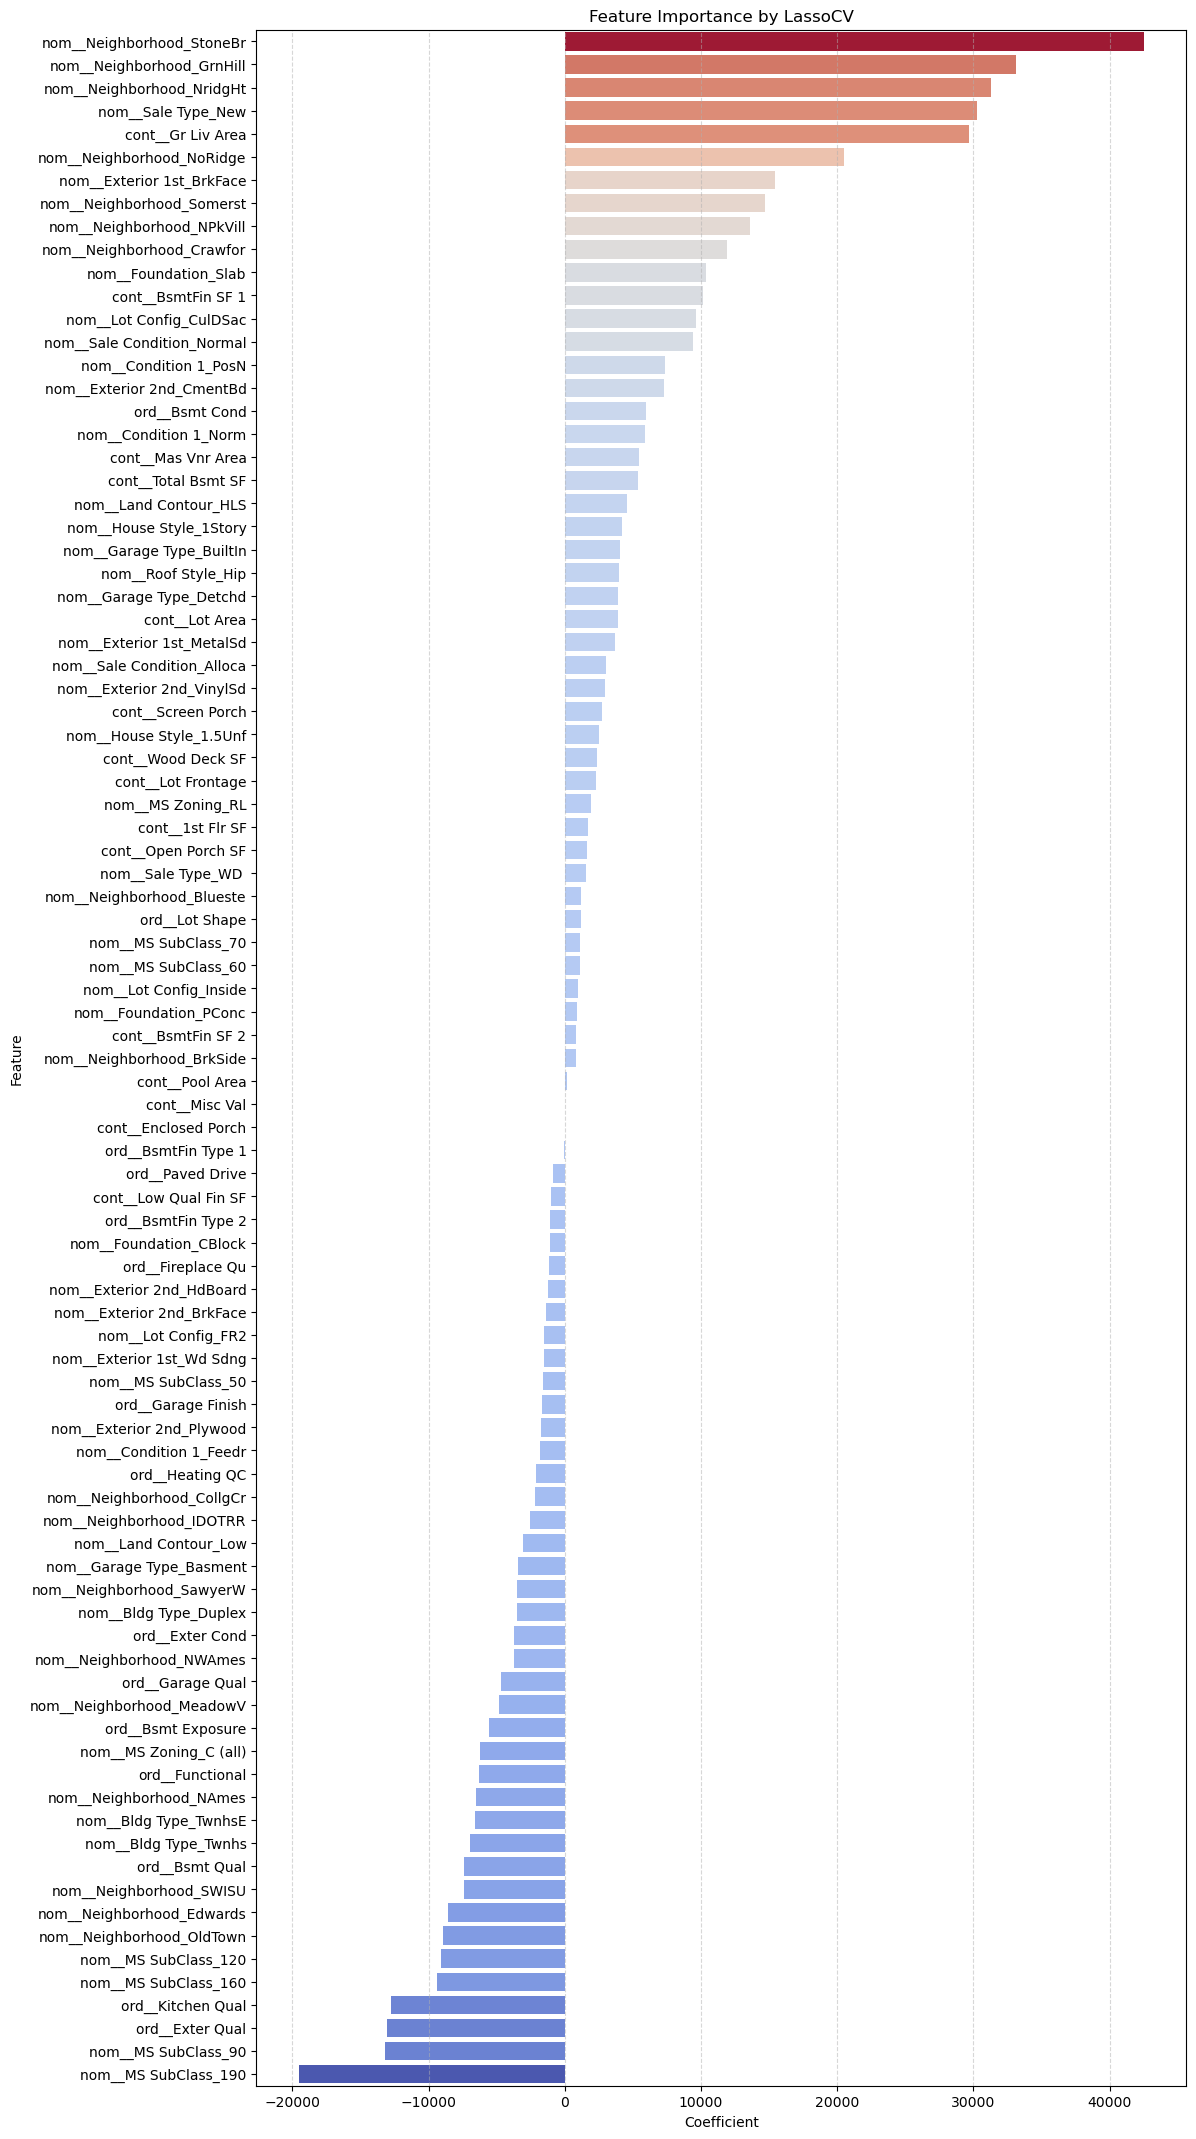

In [55]:
n_features = coef_df.shape[0]
height = max(6, 0.3*n_features)

plt.figure(figsize=(12, height))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, 
            palette='coolwarm', hue='Coefficient', dodge=False)

plt.title('Feature Importance by LassoCV')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend([],[], frameon=False)
plt.show()

In [56]:
models = {
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(cv=5),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = []

for name, model_instance in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model_instance)
    ])
    
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
    results.append({
        'Model': name, 
        'RMSE Mean': -np.mean(scores),
        'RMSE Std': np.std(scores)
    })
    
results_df = pd.DataFrame(results).sort_values(by='RMSE Mean')
print(results_df)

c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [10, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246:

              Model     RMSE Mean     RMSE Std
1           LassoCV  25600.906419  1608.130680
0  LinearRegression  25786.107648  1231.044736
2      RandomForest  26505.174072  1874.580792
3           XGBoost  26862.408984  1723.106745


c:\Users\konec\Miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [57]:
# The results of the model testing shows that LassoCV and LinearRegression has the lower RMSE Mean, but
# LassoCV with a bit higher std but its the best model representing the data. The feature selection could
# could make this model the best one.

In [58]:
# Tuning de hiperparámetros
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X, y)
print(f"Best RMSE: {-grid_search.best_score_:.2f}")
print("Best params:", grid_search.best_params_)

Best RMSE: 26449.84
Best params: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


In [ ]:
pipe_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators =100, random_state=42, verbosity=0))
])

param_grid = {
    'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [3, 5, 7, 10]
}

grid_search = GridSearchCV(estimator=pipe_xgboost, 
                           param_grid=param_grid,
                           cv=5, 
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=1
                           )

grid_search.fit(X, y)
best_index = grid_search.best_index_
std_rmse = grid_search.cv_results_['std_test_score'][best_index]

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (RMSE):", -grid_search.best_score_)
print("Mejor score (std_RMSE):", std_rmse)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
Mejor score (RMSE): 23610.932421875
Mejor score (RMSE): 936.7754695296521


In [ ]:
# The GridSearchCV for XGBoost get a better mean for the RMSE and std score than the other models, improving the Lasso
# and RandomForestRegressor, this is for it's capabiilities of capturing no linear relationships and selectiong and
# automated selection of relevant variables.